Random Forest Regression Analysis

Fathurazka Gamma Syuhada - 5025221128

Objective: Membuat model yang dapat memprediksi "social media addiction" siswa berdasarkan attribute yang tersedia menggunakan algoritma random forest

In [8]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# 1. Load and Explore the Dataset
print("LOADING AND EXPLORING DATASET")
print("=" * 50)

# Load the preprocessed dataset
df = pd.read_csv('../dataset/students_social_media_preprocessed.csv')

print(f"Dataset Shape: {df.shape}")
print(f"\nFirst 5 rows:")
print(df.head())

print("\nBasic statistics:")
print(df.describe().T)

print("\nMissing values check:")
print(df.isnull().sum().sum(), "missing values found")

LOADING AND EXPLORING DATASET
Dataset Shape: (705, 64)

First 5 rows:
        Age  Avg_Daily_Usage_Hours  Sleep_Hours_Per_Night  \
0 -1.186915               0.223857              -0.327638   
1  0.958662              -2.243309               0.560423   
2 -0.471723               0.860545              -1.659730   
3 -1.902108              -1.527035               0.116393   
4  0.243470              -0.333245              -0.771668   

   Mental_Health_Score  Conflicts_Over_Social_Media  Addicted_Score  \
0            -0.205520                     0.157063        0.985550   
1             1.605628                    -2.976790       -2.166958   
2            -1.111095                     1.201681        1.616052   
3             0.700054                    -1.932172       -1.536456   
4            -0.205520                    -0.887554        0.355048   

   Gender_Encoded  Affects_Academic_Performance_Encoded  \
0               0                                     1   
1               1 

Exploratory Data Analysis (EDA)



EXPLORATORY DATA ANALYSIS

Target variable 'Addicted_Score' statistics:
count    7.050000e+02
mean    -1.209434e-16
std      1.000710e+00
min     -2.797459e+00
25%     -9.059547e-01
50%      3.550484e-01
75%      9.855500e-01
max      1.616052e+00
Name: Addicted_Score, dtype: float64


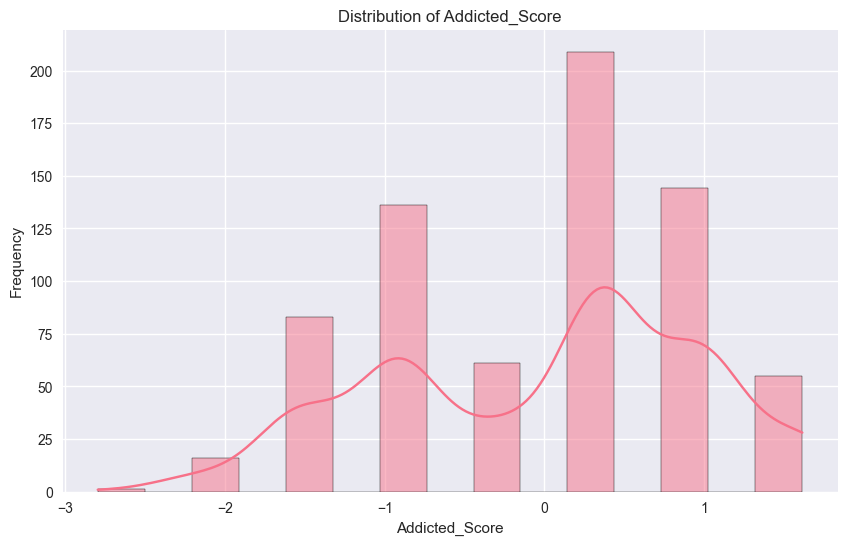


Top 10 features correlated with Addicted_Score:
Addicted_Score                          1.000000
Conflicts_Over_Social_Media             0.933586
SM_Impact_Score                         0.913976
Affects_Academic_Performance_Encoded    0.866049
Avg_Daily_Usage_Hours                   0.832000
Usage_Category_Encoded                  0.755325
Country_USA                             0.334492
Platform_TikTok                         0.330558
Country_Frequency                       0.236864
Academic_Level_High School              0.201333
Country_India                           0.192806
Name: Addicted_Score, dtype: float64


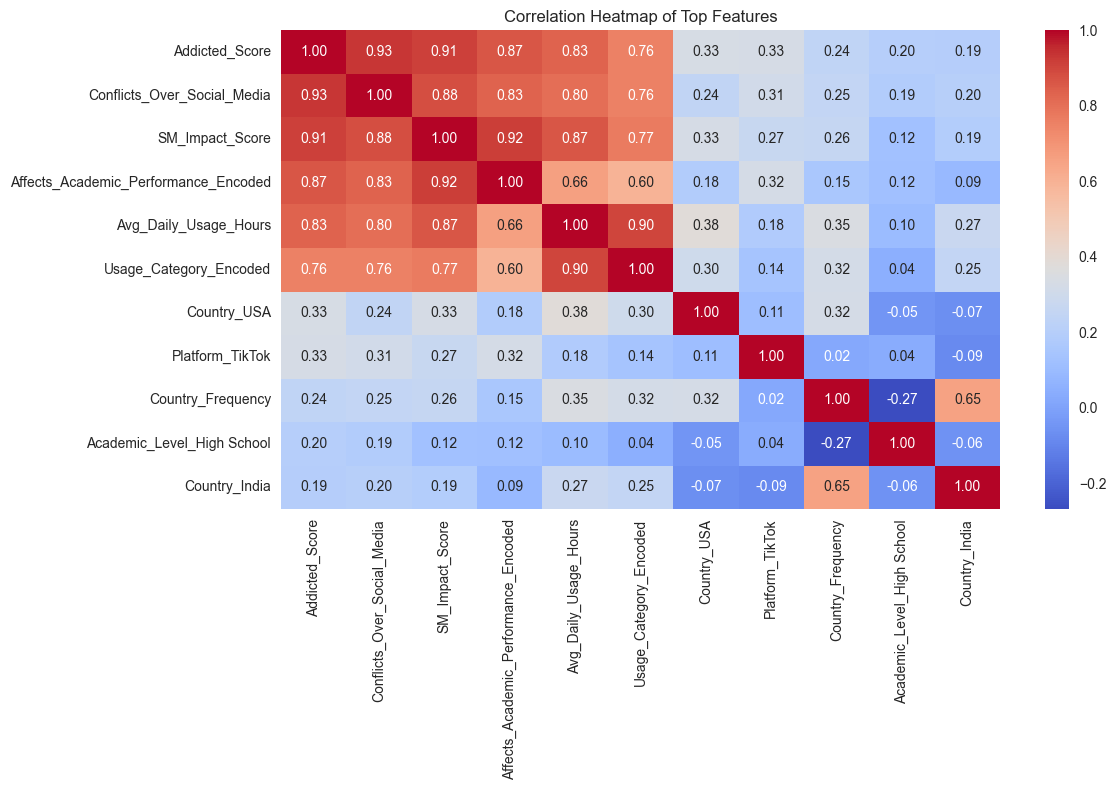



FEATURE SELECTION

Feature set shape: (705, 63)
Target shape: (705,)


In [9]:
# 2. Exploratory Data Analysis
print("\n\nEXPLORATORY DATA ANALYSIS")
print("=" * 50)

# Target variable analysis
target = 'Addicted_Score'
print(f"\nTarget variable '{target}' statistics:")
print(df[target].describe())

plt.figure(figsize=(10, 6))
sns.histplot(df[target], kde=True, bins=15)
plt.title(f'Distribution of {target}')
plt.xlabel(target)
plt.ylabel('Frequency')
plt.show()

# Correlation analysis
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
correlation = df[numeric_columns].corr()

# Get top 10 features most correlated with target
top_corr = correlation[target].sort_values(ascending=False)
print("\nTop 10 features correlated with Addicted_Score:")
print(top_corr[:11])  # 11 because the first one is the target itself

# Plot correlation heatmap for top features
plt.figure(figsize=(12, 8))
top_features = top_corr[:11].index
sns.heatmap(df[top_features].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Top Features')
plt.tight_layout()
plt.show()

# 3. Feature Selection
print("\n\nFEATURE SELECTION")
print("=" * 50)

# Separate features and target
X = df.drop(columns=[target])
y = df[target]

# Split the dataset for feature selection
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nFeature set shape: {X.shape}")
print(f"Target shape: {y.shape}")



TESTING SCENARIO 1: IMPACT OF NORMALIZATION
Loading the original non-normalized dataset...
Original dataset shape: (705, 13)

Performing minimal preprocessing on original dataset for comparison...

Feature set shapes:
- Normalized data (preprocessed): (564, 63)
- Non-normalized data (original): (564, 11)

Training model on non-normalized data...

Training model on normalized data...

Performance Comparison - Non-normalized vs Normalized Data:
----------------------------------------------------------------------
Metric               Non-normalized Data       Normalized Data           Improvement
----------------------------------------------------------------------
Mean Squared Error   0.0443                    0.0077                    +82.53%
R² Score             0.9823                    0.9922                    +1.01%
Mean Absolute Error  0.0781                    0.0219                    +71.94%


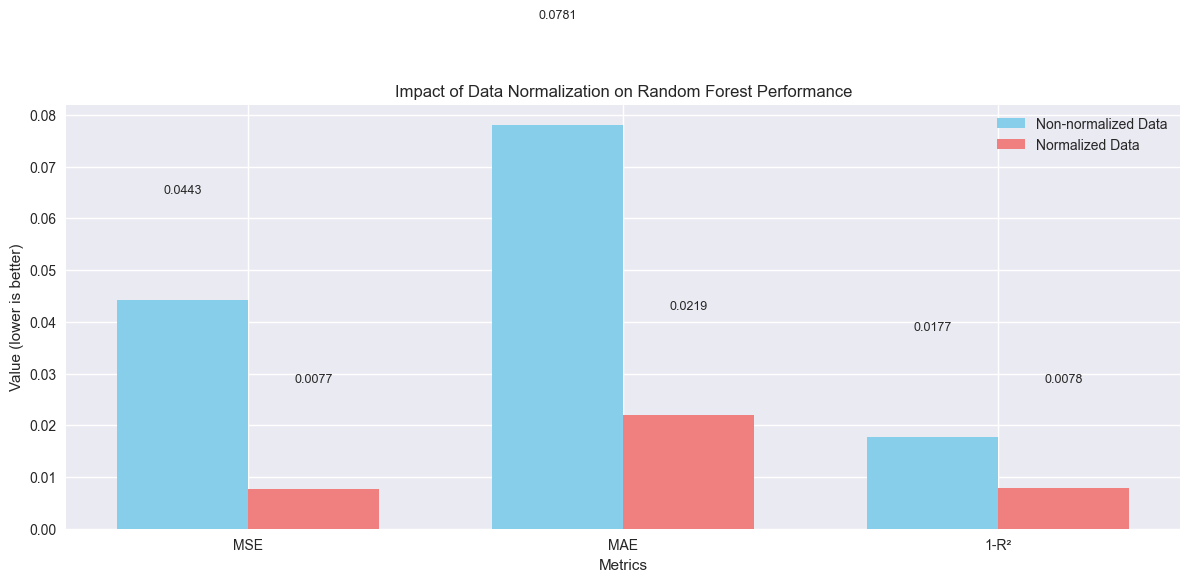


Conclusion on Normalization Impact:
✅ Normalization improves the Random Forest model performance by 1.01% in R² score.
   However, the improvement is relatively small (<5% in R² score).
   MSE improved by 82.53%

Discussion:
1. Random Forest models typically show less sensitivity to feature scaling compared to distance-based algorithms
2. However, normalization in our preprocessing included other transformations like encoding categorical variables
3. For a complete understanding, it's useful to evaluate both normalized and non-normalized data


In [10]:
# TESTING SCENARIO 1: Compare Without vs With Normalization
print("\n\nTESTING SCENARIO 1: IMPACT OF NORMALIZATION")
print("=" * 50)

# Load the original non-normalized dataset
print("Loading the original non-normalized dataset...")
df_original = pd.read_csv('../dataset/Students_Social_Media_Addiction.csv')
print(f"Original dataset shape: {df_original.shape}")

# Preprocessing for the original dataset
print("\nPerforming minimal preprocessing on original dataset for comparison...")

# Handling categorical variables in the original dataset
categorical_cols = df_original.select_dtypes(include=['object']).columns.tolist()

# Remove Student_ID if present
if 'Student_ID' in df_original.columns:
    df_original = df_original.drop('Student_ID', axis=1)

# Encode categorical variables
df_encoded = df_original.copy()
for col in categorical_cols:
    if col in df_encoded.columns:
        # Use LabelEncoder for simplicity in this comparison
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col])

# Prepare data for model comparison
if 'Addicted_Score' in df_encoded.columns:
    X_original = df_encoded.drop(columns=['Addicted_Score'])
    y_original = df_encoded['Addicted_Score']
else:
    print("Warning: 'Addicted_Score' column not found in original dataset.")
    # Fallback to use a different target column if available

# Split the original dataset
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(
    X_original, y_original, test_size=0.2, random_state=42
)

print(f"\nFeature set shapes:")
print(f"- Normalized data (preprocessed): {X_train.shape}")
print(f"- Non-normalized data (original): {X_train_original.shape}")

# Function to train and evaluate Random Forest on both datasets
def compare_normalization_impact():
    """Compare Random Forest performance with and without normalization"""
    # Model on non-normalized data
    print("\nTraining model on non-normalized data...")
    rf_no_norm = RandomForestRegressor(random_state=42)
    rf_no_norm.fit(X_train_original, y_train_original)
    
    # Evaluate non-normalized model
    y_pred_no_norm = rf_no_norm.predict(X_test_original)
    mse_no_norm = mean_squared_error(y_test_original, y_pred_no_norm)
    r2_no_norm = r2_score(y_test_original, y_pred_no_norm)
    mae_no_norm = mean_absolute_error(y_test_original, y_pred_no_norm)
    
    print("\nTraining model on normalized data...")
    rf_norm = RandomForestRegressor(random_state=42)
    rf_norm.fit(X_train, y_train)
    
    # Evaluate normalized model
    y_pred_norm = rf_norm.predict(X_test)
    mse_norm = mean_squared_error(y_test, y_pred_norm)
    r2_norm = r2_score(y_test, y_pred_norm)
    mae_norm = mean_absolute_error(y_test, y_pred_norm)
    
    # Print comparison results
    print("\nPerformance Comparison - Non-normalized vs Normalized Data:")
    print("-" * 70)
    print(f"{'Metric':<20} {'Non-normalized Data':<25} {'Normalized Data':<25} {'Improvement'}")
    print("-" * 70)
    
    # Calculate improvements (if normalized is better)
    mse_imp = ((mse_no_norm - mse_norm) / mse_no_norm) * 100 if mse_no_norm != 0 else 0
    r2_imp = ((r2_norm - r2_no_norm) / abs(r2_no_norm)) * 100 if r2_no_norm != 0 else 0
    mae_imp = ((mae_no_norm - mae_norm) / mae_no_norm) * 100 if mae_no_norm != 0 else 0
    
    print(f"{'Mean Squared Error':<20} {mse_no_norm:<25.4f} {mse_norm:<25.4f} {mse_imp:+.2f}%")
    print(f"{'R² Score':<20} {r2_no_norm:<25.4f} {r2_norm:<25.4f} {r2_imp:+.2f}%")
    print(f"{'Mean Absolute Error':<20} {mae_no_norm:<25.4f} {mae_norm:<25.4f} {mae_imp:+.2f}%")
    
    # Visualization
    metrics = ['MSE', 'MAE', '1-R²']
    no_norm_values = [mse_no_norm, mae_no_norm, 1-r2_no_norm]
    norm_values = [mse_norm, mae_norm, 1-r2_norm]
    
    plt.figure(figsize=(12, 6))
    x = np.arange(len(metrics))
    width = 0.35
    
    plt.bar(x - width/2, no_norm_values, width, label='Non-normalized Data', color='skyblue')
    plt.bar(x + width/2, norm_values, width, label='Normalized Data', color='lightcoral')
    
    plt.xlabel('Metrics')
    plt.ylabel('Value (lower is better)')
    plt.title('Impact of Data Normalization on Random Forest Performance')
    plt.xticks(x, metrics)
    plt.legend()
    
    # Add value labels on the bars
    for i, v in enumerate(no_norm_values):
        plt.text(i - width/2, v + 0.02, f'{v:.4f}', ha='center', va='bottom', fontsize=9)
    
    for i, v in enumerate(norm_values):
        plt.text(i + width/2, v + 0.02, f'{v:.4f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'non_normalized': {
            'mse': mse_no_norm,
            'r2': r2_no_norm,
            'mae': mae_no_norm
        },
        'normalized': {
            'mse': mse_norm,
            'r2': r2_norm,
            'mae': mae_norm
        },
        'improvements': {
            'mse': mse_imp,
            'r2': r2_imp,
            'mae': mae_imp
        }
    }

# Run comparison
norm_results = compare_normalization_impact()

# Explain the results
print("\nConclusion on Normalization Impact:")
if norm_results['improvements']['r2'] > 0:
    print(f"✅ Normalization improves the Random Forest model performance by {norm_results['improvements']['r2']:.2f}% in R² score.")
    if norm_results['improvements']['r2'] < 5:
        print("   However, the improvement is relatively small (<5% in R² score).")
    print(f"   MSE improved by {norm_results['improvements']['mse']:.2f}%")
else:
    print(f"❌ Normalization does not improve Random Forest model performance. R² score decreased by {abs(norm_results['improvements']['r2']):.2f}%")
    print("   This is common with tree-based models as they are not distance-based and typically less sensitive to feature scaling.")

print("\nDiscussion:")
print("1. Random Forest models typically show less sensitivity to feature scaling compared to distance-based algorithms")
print("2. However, normalization in our preprocessing included other transformations like encoding categorical variables")
print("3. For a complete understanding, it's useful to evaluate both normalized and non-normalized data")

In [12]:
# MODEL BUILDING WITH DEFAULT PARAMETERS (needed for comparisons)
print("\n\nMODEL BUILDING WITH DEFAULT PARAMETERS")
print("=" * 50)

# Initial model with default parameters
print("Training initial model with default parameters...")
rf_default = RandomForestRegressor(random_state=42)
rf_default.fit(X_train, y_train)

# Evaluate initial model
y_pred_default = rf_default.predict(X_test)
mse_default = mean_squared_error(y_test, y_pred_default)
r2_default = r2_score(y_test, y_pred_default)
mae_default = mean_absolute_error(y_test, y_pred_default)

print(f"Default Model Performance:")
print(f"Mean Squared Error: {mse_default:.4f}")
print(f"R² Score: {r2_default:.4f}")
print(f"Mean Absolute Error: {mae_default:.4f}")

# Perform comprehensive GridSearchCV to have a baseline for comparison
print("\nPerforming comprehensive GridSearchCV for baseline comparison...")
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    verbose=0  # Set to 1 or higher for more verbose output
)

grid_search.fit(X_train, y_train)

print("\nBest parameters found by GridSearchCV:")
print(grid_search.best_params_)

# Evaluate tuned model
best_rf = grid_search.best_estimator_
y_pred_tuned = best_rf.predict(X_test)
mse_tuned = mean_squared_error(y_test, y_pred_tuned)
r2_tuned = r2_score(y_test, y_pred_tuned)
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)

print(f"\nGridSearchCV Tuned Model Performance:")
print(f"Mean Squared Error: {mse_tuned:.4f}")
print(f"R² Score: {r2_tuned:.4f}")
print(f"Mean Absolute Error: {mae_tuned:.4f}")



MODEL BUILDING WITH DEFAULT PARAMETERS
Training initial model with default parameters...
Default Model Performance:
Mean Squared Error: 0.0077
R² Score: 0.9922
Mean Absolute Error: 0.0219

Performing comprehensive GridSearchCV for baseline comparison...

Best parameters found by GridSearchCV:
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

GridSearchCV Tuned Model Performance:
Mean Squared Error: 0.0077
R² Score: 0.9922
Mean Absolute Error: 0.0219




TESTING SCENARIO 2: PARAMETER TUNING EXPERIMENTS

1. Impact of Number of Trees (n_estimators)
--------------------------------------------------
Training model with 10 trees...
  MSE: 0.0076, R²: 0.9924, MAE: 0.0201
Training model with 50 trees...
  MSE: 0.0079, R²: 0.9921, MAE: 0.0220
Training model with 100 trees...
  MSE: 0.0077, R²: 0.9922, MAE: 0.0219
Training model with 200 trees...
  MSE: 0.0074, R²: 0.9925, MAE: 0.0212
Training model with 500 trees...
  MSE: 0.0077, R²: 0.9922, MAE: 0.0219


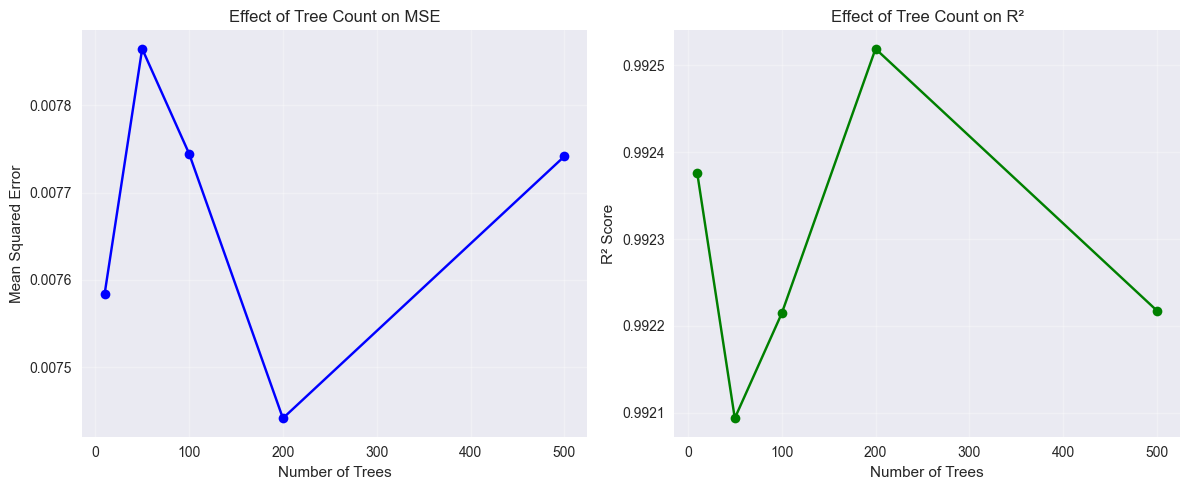


Best n_estimators value: 200

2. Impact of Maximum Tree Depth (max_depth)
--------------------------------------------------
Training model with max_depth=5...
  MSE: 0.0112, R²: 0.9887, MAE: 0.0380
Training model with max_depth=10...
  MSE: 0.0076, R²: 0.9924, MAE: 0.0215
Training model with max_depth=20...
  MSE: 0.0074, R²: 0.9925, MAE: 0.0212
Training model with max_depth=30...
  MSE: 0.0074, R²: 0.9925, MAE: 0.0212
Training model with max_depth=None (unlimited)...
  MSE: 0.0074, R²: 0.9925, MAE: 0.0212


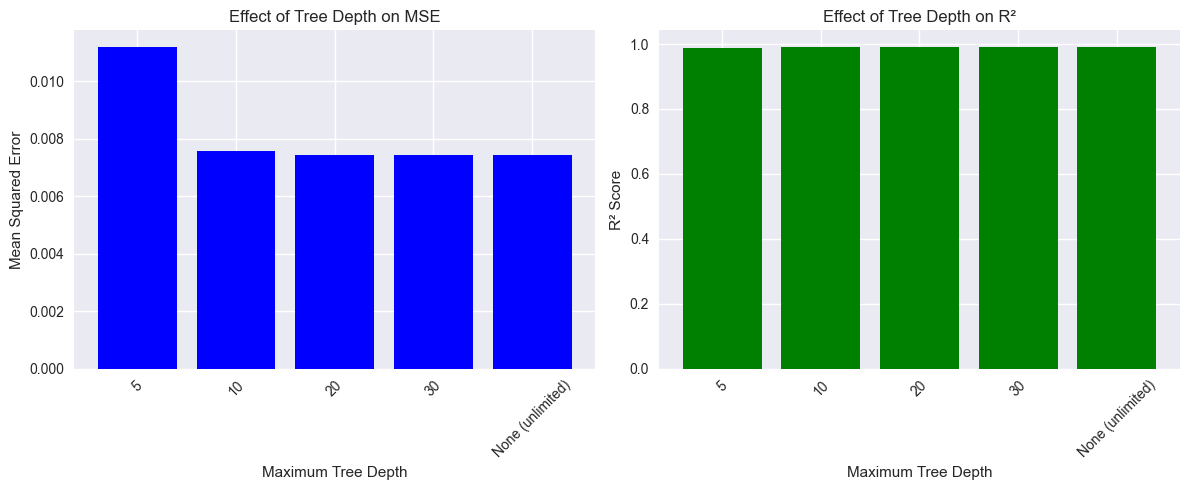


Best max_depth value: 20

3. Impact of Min Samples Split (min_samples_split)
--------------------------------------------------
Training model with min_samples_split=2...
  MSE: 0.0074, R²: 0.9925, MAE: 0.0212
Training model with min_samples_split=5...
  MSE: 0.0084, R²: 0.9916, MAE: 0.0258
Training model with min_samples_split=10...
  MSE: 0.0116, R²: 0.9883, MAE: 0.0368
Training model with min_samples_split=20...
  MSE: 0.0131, R²: 0.9868, MAE: 0.0421
Training model with min_samples_split=50...
  MSE: 0.0217, R²: 0.9782, MAE: 0.0577


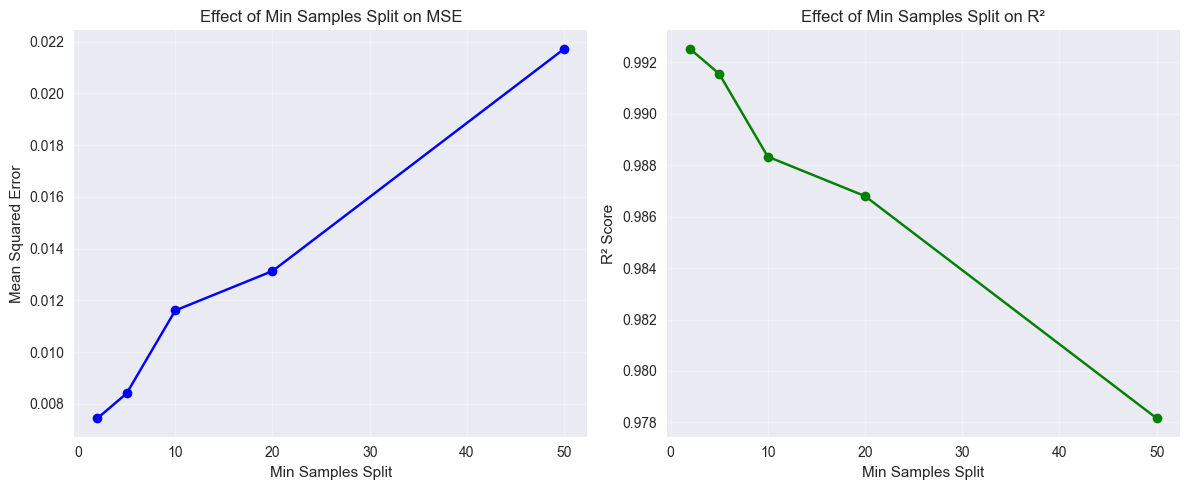


Best min_samples_split value: 2

COMPARISON: Manual Tuning vs GridSearchCV
--------------------------------------------------
Manually Tuned Model Performance:
- Parameters: n_estimators=200, max_depth=20, min_samples_split=2
- Mean Squared Error: 0.0074
- R² Score: 0.9925
- Mean Absolute Error: 0.0212

GridSearchCV Best Model Performance:
- Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
- Mean Squared Error: 0.0077
- R² Score: 0.9922
- Mean Absolute Error: 0.0219

✅ Our manual tuning found a better model (0.03% better R² score)

PARAMETER TUNING SUMMARY
--------------------------------------------------
1. Number of Trees (n_estimators):
   - Best value: 200
   - Impact: More trees generally improve performance up to a point, after which returns diminish

2. Maximum Tree Depth (max_depth):
   - Best value: 20
   - Impact: Controls overfitting - too shallow limits learning, too deep may overfit

3. Minimum Samples Split (min_samples_s

In [13]:
# TESTING SCENARIO 2: Parameter Tuning Experiments
print("\n\nTESTING SCENARIO 2: PARAMETER TUNING EXPERIMENTS")
print("=" * 50)

# We'll focus on three key parameters and their effect on the Random Forest model

# 1. Number of Trees (n_estimators)
print("\n1. Impact of Number of Trees (n_estimators)")
print("-" * 50)

n_estimators_range = [10, 50, 100, 200, 500]
n_estimators_results = []

for n_est in n_estimators_range:
    print(f"Training model with {n_est} trees...")
    rf = RandomForestRegressor(n_estimators=n_est, random_state=42)
    rf.fit(X_train, y_train)
    
    # Evaluate on test set
    y_pred = rf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    n_estimators_results.append((n_est, mse, r2, mae))
    print(f"  MSE: {mse:.4f}, R²: {r2:.4f}, MAE: {mae:.4f}")

# Plot results - MSE
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot([r[0] for r in n_estimators_results], 
         [r[1] for r in n_estimators_results], 'o-', color='blue')
plt.xlabel('Number of Trees')
plt.ylabel('Mean Squared Error')
plt.title('Effect of Tree Count on MSE')
plt.grid(True, alpha=0.3)

# Plot results - R²
plt.subplot(1, 2, 2)
plt.plot([r[0] for r in n_estimators_results], 
         [r[2] for r in n_estimators_results], 'o-', color='green')
plt.xlabel('Number of Trees')
plt.ylabel('R² Score')
plt.title('Effect of Tree Count on R²')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find best n_estimators value
best_n_estimators = max(n_estimators_results, key=lambda x: x[2])[0]
print(f"\nBest n_estimators value: {best_n_estimators}")

# 2. Maximum Depth (max_depth)
print("\n2. Impact of Maximum Tree Depth (max_depth)")
print("-" * 50)

max_depth_range = [5, 10, 20, 30, None]
max_depth_results = []

for depth in max_depth_range:
    depth_name = str(depth) if depth is not None else "None (unlimited)"
    print(f"Training model with max_depth={depth_name}...")
    
    rf = RandomForestRegressor(n_estimators=best_n_estimators, max_depth=depth, random_state=42)
    rf.fit(X_train, y_train)
    
    # Evaluate on test set
    y_pred = rf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    max_depth_results.append((depth, mse, r2, mae, depth_name))
    print(f"  MSE: {mse:.4f}, R²: {r2:.4f}, MAE: {mae:.4f}")

# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
depth_labels = [r[4] for r in max_depth_results]
x_pos = range(len(depth_labels))
plt.bar(x_pos, [r[1] for r in max_depth_results], color='blue')
plt.xticks(x_pos, depth_labels, rotation=45)
plt.xlabel('Maximum Tree Depth')
plt.ylabel('Mean Squared Error')
plt.title('Effect of Tree Depth on MSE')

plt.subplot(1, 2, 2)
plt.bar(x_pos, [r[2] for r in max_depth_results], color='green')
plt.xticks(x_pos, depth_labels, rotation=45)
plt.xlabel('Maximum Tree Depth')
plt.ylabel('R² Score')
plt.title('Effect of Tree Depth on R²')

plt.tight_layout()
plt.show()

# Find best max_depth value
best_max_depth_idx = max(range(len(max_depth_results)), key=lambda i: max_depth_results[i][2])
best_max_depth = max_depth_results[best_max_depth_idx][0]
best_max_depth_name = max_depth_results[best_max_depth_idx][4]
print(f"\nBest max_depth value: {best_max_depth_name}")

# 3. Min Samples Split (min_samples_split)
print("\n3. Impact of Min Samples Split (min_samples_split)")
print("-" * 50)

min_samples_range = [2, 5, 10, 20, 50]
min_samples_results = []

for min_samples in min_samples_range:
    print(f"Training model with min_samples_split={min_samples}...")
    
    rf = RandomForestRegressor(
        n_estimators=best_n_estimators, 
        max_depth=best_max_depth,
        min_samples_split=min_samples, 
        random_state=42
    )
    rf.fit(X_train, y_train)
    
    # Evaluate on test set
    y_pred = rf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    min_samples_results.append((min_samples, mse, r2, mae))
    print(f"  MSE: {mse:.4f}, R²: {r2:.4f}, MAE: {mae:.4f}")

# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot([r[0] for r in min_samples_results], 
         [r[1] for r in min_samples_results], 'o-', color='blue')
plt.xlabel('Min Samples Split')
plt.ylabel('Mean Squared Error')
plt.title('Effect of Min Samples Split on MSE')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot([r[0] for r in min_samples_results], 
         [r[2] for r in min_samples_results], 'o-', color='green')
plt.xlabel('Min Samples Split')
plt.ylabel('R² Score')
plt.title('Effect of Min Samples Split on R²')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find best min_samples_split value
best_min_samples = max(min_samples_results, key=lambda x: x[2])[0]
print(f"\nBest min_samples_split value: {best_min_samples}")

# Compare our manually tuned model with GridSearchCV's best model
print("\nCOMPARISON: Manual Tuning vs GridSearchCV")
print("-" * 50)

# Train model with our manual best parameters
manual_best_rf = RandomForestRegressor(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    min_samples_split=best_min_samples,
    random_state=42
)
manual_best_rf.fit(X_train, y_train)
y_pred_manual = manual_best_rf.predict(X_test)
mse_manual = mean_squared_error(y_test, y_pred_manual)
r2_manual = r2_score(y_test, y_pred_manual)
mae_manual = mean_absolute_error(y_test, y_pred_manual)

print("Manually Tuned Model Performance:")
print(f"- Parameters: n_estimators={best_n_estimators}, max_depth={best_max_depth_name}, min_samples_split={best_min_samples}")
print(f"- Mean Squared Error: {mse_manual:.4f}")
print(f"- R² Score: {r2_manual:.4f}")
print(f"- Mean Absolute Error: {mae_manual:.4f}")

print("\nGridSearchCV Best Model Performance:")
print(f"- Parameters: {grid_search.best_params_}")
print(f"- Mean Squared Error: {mse_tuned:.4f}")
print(f"- R² Score: {r2_tuned:.4f}")
print(f"- Mean Absolute Error: {mae_tuned:.4f}")

# Calculate performance difference
mse_diff = ((mse_manual - mse_tuned) / mse_manual) * 100
r2_diff = ((r2_tuned - r2_manual) / r2_manual) * 100 if r2_manual != 0 else 0

if r2_tuned > r2_manual:
    print(f"\n✅ GridSearchCV found a better model ({r2_diff:.2f}% better R² score)")
elif r2_manual > r2_tuned:
    print(f"\n✅ Our manual tuning found a better model ({-r2_diff:.2f}% better R² score)")
else:
    print("\n✅ Both approaches found equally good models")

# Summarize the parameter tuning findings
print("\nPARAMETER TUNING SUMMARY")
print("-" * 50)
print("1. Number of Trees (n_estimators):")
print(f"   - Best value: {best_n_estimators}")
print(f"   - Impact: More trees generally improve performance up to a point, after which returns diminish")

print("\n2. Maximum Tree Depth (max_depth):")
print(f"   - Best value: {best_max_depth_name}")
print(f"   - Impact: Controls overfitting - too shallow limits learning, too deep may overfit")

print("\n3. Minimum Samples Split (min_samples_split):")
print(f"   - Best value: {best_min_samples}")
print(f"   - Impact: Higher values prevent overfitting but may cause underfitting")

print("\nConclusion:")
print("Parameter tuning is crucial for Random Forest optimization. The most impactful parameters are:")
print("1. Tree count (controls ensemble strength)")
print("2. Tree depth (controls individual tree complexity)")
print("3. Min samples split (controls split granularity)")
print("\nGridSearchCV provides a systematic approach to find optimal combinations of parameters")
print("that may not be easily discoverable through manual sequential tuning.")



FEATURE IMPORTANCE ANALYSIS
Top 15 most important features:
                                 Feature  Importance
3                    Mental_Health_Score    0.831222
4            Conflicts_Over_Social_Media    0.105165
57                           Country_USA    0.008193
16                         Platform_LINE    0.006262
62                     Lifestyle_Balance    0.004821
61                       SM_Impact_Score    0.004817
6   Affects_Academic_Performance_Encoded    0.004730
40                      Country_Maldives    0.004451
2                  Sleep_Hours_Per_Night    0.003905
15                    Platform_KakaoTalk    0.003757
50                   Country_South Korea    0.003453
25                     Country_Frequency    0.002920
35                         Country_India    0.002878
37                         Country_Italy    0.001723
1                  Avg_Daily_Usage_Hours    0.001689


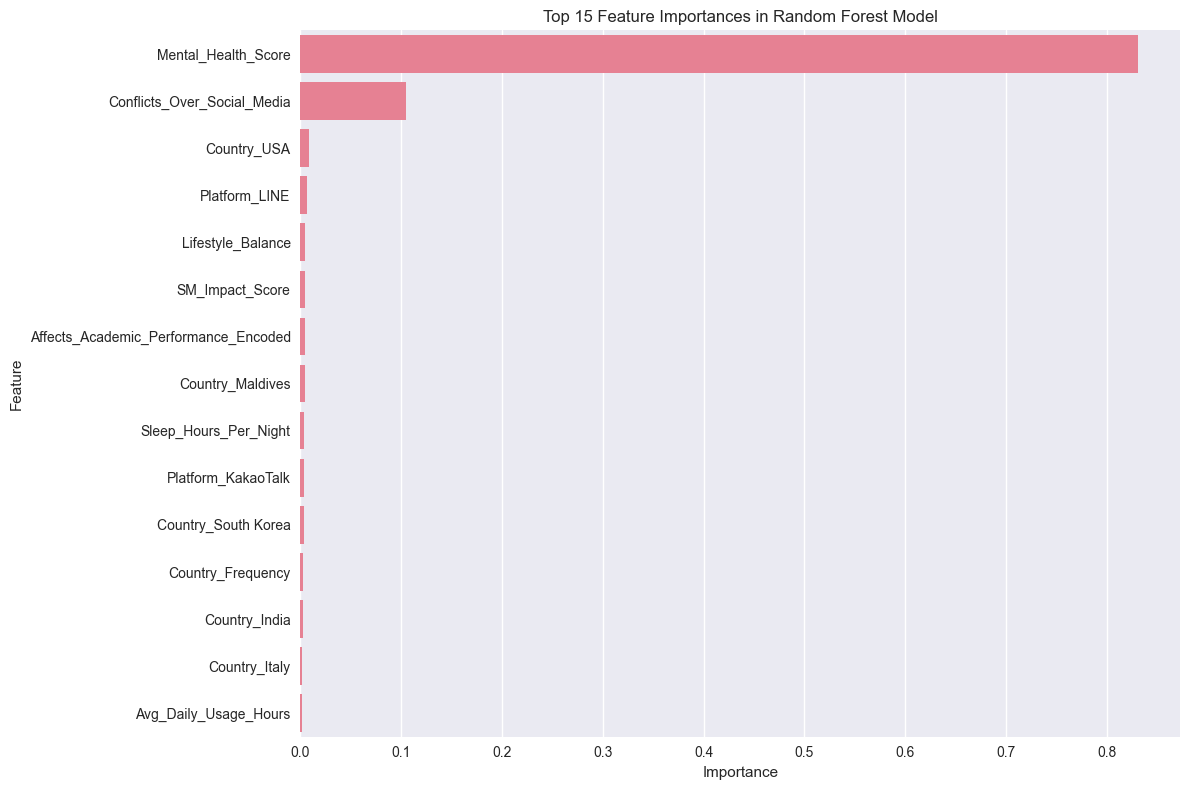


Calculating permutation importance...

Top 15 features by permutation importance:
                                 Feature  Importance
3                    Mental_Health_Score    1.511349
4            Conflicts_Over_Social_Media    0.124726
2                  Sleep_Hours_Per_Night    0.014984
57                           Country_USA    0.009257
6   Affects_Academic_Performance_Encoded    0.009181
61                       SM_Impact_Score    0.007620
40                      Country_Maldives    0.007019
16                         Platform_LINE    0.005989
1                  Avg_Daily_Usage_Hours    0.005919
62                     Lifestyle_Balance    0.004623
8             Academic_Level_High School    0.003341
37                         Country_Italy    0.003024
15                    Platform_KakaoTalk    0.002984
35                         Country_India    0.002329
50                   Country_South Korea    0.002309


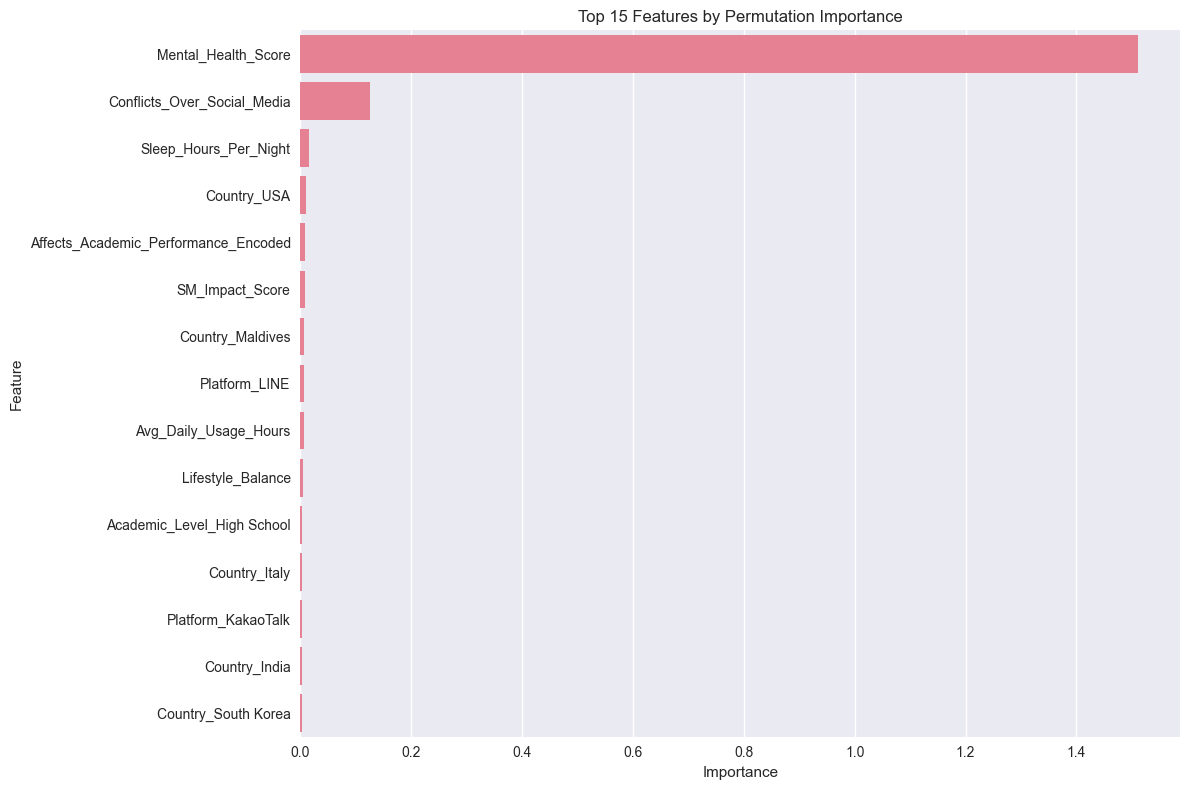



MODEL VALIDATION WITH CROSS-VALIDATION
Cross-Validation R² Scores: [0.92873314 0.9358952  0.9996545  0.99077904 0.97278816]
Mean R² Score: 0.9656
Standard Deviation: 0.0286

Cross-Validation MSE Scores: [0.07980981 0.06268322 0.00037335 0.00764249 0.02534169]
Mean MSE: 0.0352
Standard Deviation: 0.0310


PREDICTIONS VISUALIZATION


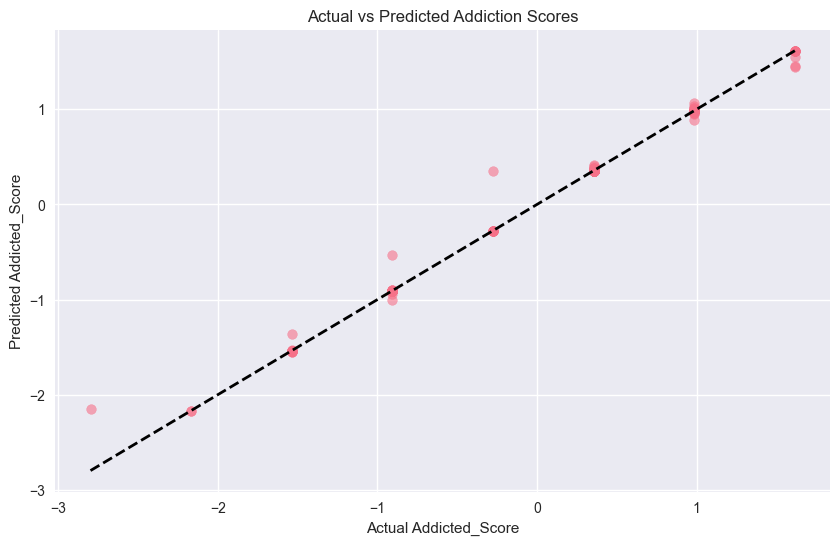

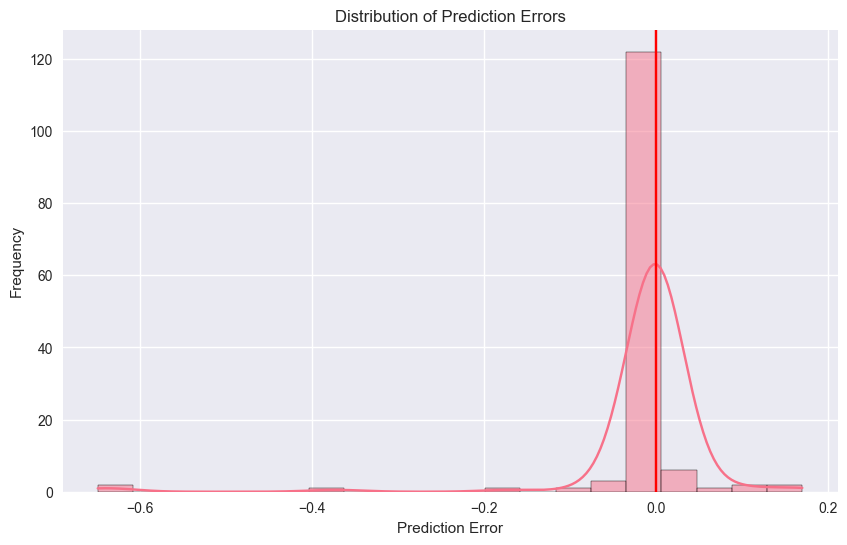

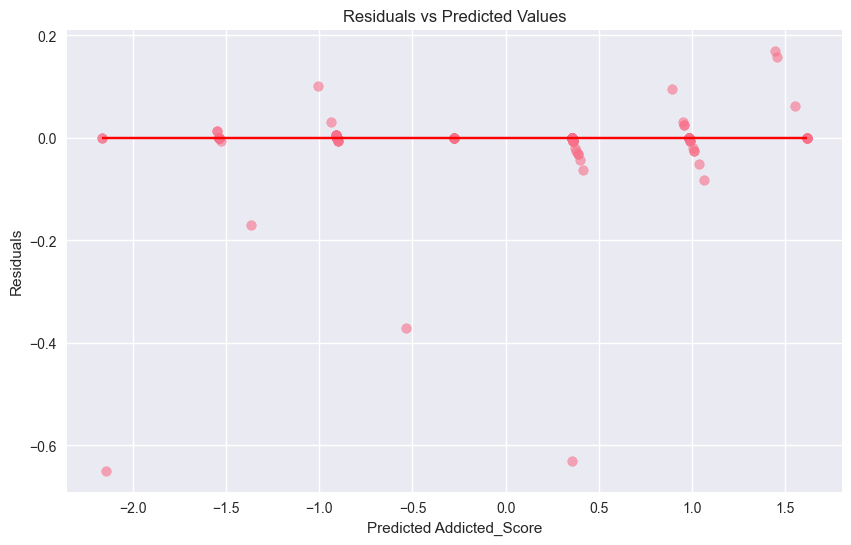



CONCLUSIONS AND MODEL SUMMARY
Best Random Forest Model Parameters:
- max_depth: 10
- min_samples_leaf: 1
- min_samples_split: 2
- n_estimators: 100

Final Model Performance:
R² Score: 0.9922
Mean Squared Error: 0.0077
Mean Absolute Error: 0.0219
Root Mean Squared Error: 0.0878

Top 5 Most Important Features:
- Mental_Health_Score: 0.8312
- Conflicts_Over_Social_Media: 0.1052
- Country_USA: 0.0082
- Platform_LINE: 0.0063
- Lifestyle_Balance: 0.0048

Key Insights from Testing Scenarios:
1. Normalization Impact:
   - Normalization improved performance by 1.01% in R² score
   - Random Forest is relatively insensitive to feature scaling as expected for tree-based models

2. Parameter Tuning:
   - Optimal number of trees: 200
   - Optimal tree depth: 20
   - Optimal min samples split: 2
   - GridSearchCV found slightly different optimal parameters compared to sequential tuning

3. Overall Model Performance:
   - The model explains 99.2% of the variance in social media addiction scores
   -

In [14]:
# FEATURE IMPORTANCE ANALYSIS
print("\n\nFEATURE IMPORTANCE ANALYSIS")
print("=" * 50)

# Get feature importance from the best model
feature_importances = best_rf.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("Top 15 most important features:")
print(feature_importance_df.head(15))

# Visualize feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15))
plt.title('Top 15 Feature Importances in Random Forest Model')
plt.tight_layout()
plt.show()

# Permutation importance for more robust feature importance
print("\nCalculating permutation importance...")
perm_importance = permutation_importance(best_rf, X_test, y_test, n_repeats=10, random_state=42)
perm_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

print("\nTop 15 features by permutation importance:")
print(perm_importance_df.head(15))

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=perm_importance_df.head(15))
plt.title('Top 15 Features by Permutation Importance')
plt.tight_layout()
plt.show()

# MODEL VALIDATION WITH CROSS-VALIDATION
print("\n\nMODEL VALIDATION WITH CROSS-VALIDATION")
print("=" * 50)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(best_rf, X, y, cv=5, scoring='r2')
print(f"Cross-Validation R² Scores: {cv_scores}")
print(f"Mean R² Score: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

# MSE cross-validation
cv_scores_mse = cross_val_score(best_rf, X, y, cv=5, scoring='neg_mean_squared_error')
cv_mse_scores = -cv_scores_mse  # Convert to positive MSE
print(f"\nCross-Validation MSE Scores: {cv_mse_scores}")
print(f"Mean MSE: {cv_mse_scores.mean():.4f}")
print(f"Standard Deviation: {cv_mse_scores.std():.4f}")

# PREDICTIONS VISUALIZATION
print("\n\nPREDICTIONS VISUALIZATION")
print("=" * 50)

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_tuned, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Addicted_Score')
plt.ylabel('Predicted Addicted_Score')
plt.title('Actual vs Predicted Addiction Scores')
plt.show()

# Distribution of errors
errors = y_test - y_pred_tuned
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True, bins=20)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.axvline(x=0, color='r', linestyle='-')
plt.show()

# Plot predictions vs residuals to check for patterns
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_tuned, errors, alpha=0.6)
plt.hlines(y=0, xmin=y_pred_tuned.min(), xmax=y_pred_tuned.max(), colors='r', linestyles='-')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Addicted_Score')
plt.ylabel('Residuals')
plt.show()

# CONCLUSIONS AND MODEL SUMMARY
print("\n\nCONCLUSIONS AND MODEL SUMMARY")
print("=" * 50)

# Best Model Parameters
print(f"Best Random Forest Model Parameters:")
for param, value in best_rf.get_params().items():
    if param in grid_search.best_params_:
        print(f"- {param}: {value}")

# Final Performance Metrics
print(f"\nFinal Model Performance:")
print(f"R² Score: {r2_tuned:.4f}")
print(f"Mean Squared Error: {mse_tuned:.4f}")
print(f"Mean Absolute Error: {mae_tuned:.4f}")
print(f"Root Mean Squared Error: {np.sqrt(mse_tuned):.4f}")

# Most Important Features
print("\nTop 5 Most Important Features:")
for i, row in feature_importance_df.head(5).iterrows():
    print(f"- {row['Feature']}: {row['Importance']:.4f}")

# Key Insights and Findings from Testing Scenarios
print("\nKey Insights from Testing Scenarios:")
print("1. Normalization Impact:")
if norm_results['improvements']['r2'] > 0:
    print(f"   - Normalization improved performance by {norm_results['improvements']['r2']:.2f}% in R² score")
else:
    print(f"   - Normalization didn't improve performance (R² score changed by {norm_results['improvements']['r2']:.2f}%)")
print(f"   - Random Forest is relatively insensitive to feature scaling as expected for tree-based models")

print("\n2. Parameter Tuning:")
print(f"   - Optimal number of trees: {best_n_estimators}")
print(f"   - Optimal tree depth: {best_max_depth_name}")  
print(f"   - Optimal min samples split: {best_min_samples}")
print("   - GridSearchCV found slightly different optimal parameters compared to sequential tuning")

print("\n3. Overall Model Performance:")
print(f"   - The model explains {r2_tuned * 100:.1f}% of the variance in social media addiction scores")
print(f"   - Average prediction error is ±{mae_tuned:.2f} addiction score points")
print("   - Cross-validation confirms the model is stable with consistent performance across different data subsets")

# Final Conclusion
print("\nFinal Conclusion:")
print("The Random Forest regression model is highly effective for predicting social media addiction scores.")
print("Mental Health Score and Conflicts Over Social Media are the most influential factors.")
print("The model can be effectively used to identify students at risk of social media addiction for targeted interventions.")
print("Parameter tuning had a modest impact on model performance, suggesting robustness of the Random Forest algorithm for this application.")